In [3]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import init_notebook_mode

In [1]:
from pymarkowitz import *

In [4]:
init_notebook_mode(connected=True)

In [5]:
%load_ext autoreload
%autoreload 2

## Data Preparation
- Selecting 15 Assets with 1000 Observations
- Calculate Annualized Mean Return and Covariance Matrix and Beta

In [6]:
sp500 = pd.read_csv("datasets/sp500_1990_2000.csv", index_col='DATE').drop(["Unnamed: 0"], axis=1)
sp500.head()

AAPL   ABMD    ABT   ADBE     ADM    ADSK     AEP     AFL  \
DATE                                                                     
01/02/1990  1.330  5.875  3.874  1.282  8.4918  5.0313  33.125  1.1750   
01/03/1990  1.339  5.813  3.888  1.345  8.5382  5.1563  33.000  1.1500   
01/04/1990  1.344  5.625  3.881  1.408  8.4918  5.0313  32.500  1.1250   
01/05/1990  1.348  5.750  3.839  1.440  8.0741  5.0313  31.750  1.1250   
01/08/1990  1.357  5.750  3.839  1.456  8.2134  4.9844  31.625  1.1333   

                 AIG     AJG  ...      WEC     WFC     WHR     WMB     WMT  \
DATE                          ...                                            
01/02/1990  148.9705  6.1875  ...  10.6667  2.8281  32.250  4.9662  5.9219   
01/03/1990  148.7940  6.1563  ...  10.4583  2.7031  32.375  5.0755  5.8906   
01/04/1990  146.6759  6.1563  ...  10.4167  2.6719  32.750  4.9194  5.8594   
01/05/1990  142.2633  6.1563  ...  10.2500  2.5938  32.000  4.9350  5.7969   
01/08/1990  141.3807  6.1563  ...  10.1667  2.6719  32.250  4.9974  5.8750   

                 WY      XOM    XRAY      XRX    ZION  
DATE                                                   
01/02/1990  11.6129  12.5000  1.0417  25.4128  3.5000  
01/03/1990  11.3571  12.3750  1.0417  25.5775  3.5625  
01/04/1990  11.2548  12.2500  1.0000  25.6324  3.5625  
01/05/1990  11.2036  12.2188  1.0625  25.6873  3.5625  
01/08/1990  11.2036  12.3750  1.0208  25.5226  3.5625  

[5 rows x 203 columns]

In [7]:
selected = sp500.iloc[:1000, np.random.choice(np.arange(0, sp500.shape[1]), 15, replace=False)]
selected.head()

INTC     WFC      CVX      EIX      JPM     SYY     ALK     DTE  \
DATE                                                                            
01/02/1990  1.1250  2.8281  17.3125  20.1250  10.0417  4.0938  5.3438  25.625   
01/03/1990  1.0938  2.7031  17.0000  19.9375  10.3333  3.9844  5.2813  25.375   
01/04/1990  1.1172  2.6719  16.7813  19.6250  10.3750  3.9063  5.2500  25.000   
01/05/1990  1.1094  2.5938  16.5313  19.1875  10.4167  3.9063  5.3438  24.875   
01/08/1990  1.1250  2.6719  16.6563  19.3125  10.4167  3.8750  5.3750  24.750   

               BLL      BK    NOC     IFF     DHR     OKE      LB  
DATE                                                               
01/02/1990  2.1172  5.4159  8.165  22.417  0.7342  3.5018  8.4007  
01/03/1990  2.0547  5.4987  8.165  22.417  0.7402  3.5429  8.6035  
01/04/1990  2.0781  5.4656  8.108  22.542  0.7461  3.4608  8.6325  
01/05/1990  2.0938  5.4987  8.165  22.333  0.7342  3.3650  8.4297  
01/08/1990  2.1250  5.4490  8.391  22.208  0.7283  3.4061  8.4297

In [8]:
px.line(pd.melt(selected.reset_index(), id_vars='DATE'), x='DATE', y='value', color='variable', title='Price from 1990 - 1993')

In [9]:
px.line(pd.melt((selected/selected.iloc[0]).reset_index(), id_vars='DATE'), x='DATE', y='value', color='variable', title='Cumulative from 1990 - 1993')

In [10]:
ret_generator = ReturnGenerator(selected)

In [11]:
mu_return = ret_generator.calc_mean_return(method='geometric')

In [12]:
daily_return = ret_generator.calc_return(method='daily')

In [13]:
mom_generator = MomentGenerator(daily_return)

In [14]:
cov_matrix = mom_generator.calc_cov_mat(method='exp', decay=0.94, span=30)

In [15]:
beta_vec = mom_generator.calc_beta(beta_vec=sp500.iloc[:1000].pct_change().dropna(how='any').sum(axis=1)/sp500.shape[1], method='exp', decay=0.94, span=30)

## Performing Simulations
- Initialization
- Selecting X/Y Variable
- Adding Portfolio Composition Constraints to Weight Generation

### Initialization
- Setting Up An Optimizer with Mean Return, Covariance Matrix and Beta
- Beta is optional, but if no beta is given then no constraints/objectives that use beta can be performed

In [22]:
PortOpt = Optimizer(mu_return, cov_matrix, beta_vec)

### Random Weight Generation
- It is often hard to construct an entirely randomized weight.
- With Normal Distribution/Uniform Distribution, if we have a lot of assets in the portfolio, then they tend to converge towards equal weight
- Optimizer uses np.random.dirichlet distribution to generate randomized weight that allows for concentrated/diversified weights creation
- However, np.random.dirichlet achieves its desirable result when passing in a weight_bound that applies universally to all the assets, in a long only scenario, with no leverage
- If passing in individual bounds for each individual asset, then random weights are generated with normal distribution, in the case of a large number of assets, narrows the range of portfolio allocation

### Simulation Metrics Options
- Call metric_options() to check all available options

In [44]:
PortOpt.metric_options()

{'leverage': <Signature (w)>,
 'num_assets': <Signature (w)>,
 'concentration': <Signature (w, top_holdings)>,
 'correlation': <Signature (w)>,
 'diversification': <Signature (w)>,
 'variance': <Signature (w)>,
 'volatility': <Signature (w)>,
 'skew': <Signature (w)>,
 'kurt': <Signature (w)>,
 'moment': <Signature (w)>,
 'risk_parity': <Signature (w)>,
 'expected_return': <Signature (w)>,
 'sharpe': <Signature (w, risk_free)>,
 'beta': <Signature (w)>,
 'treynor': <Signature (w, risk_free)>,
 'jenson_alpha': <Signature (w, risk_free, market_return)>}

#### Example: Efficient Frontier
- Theoretically, efficient frontier should be symmetric along an axis parallel to x-axis
- With optimization goals in mind, the lower half of the efficient frontier will not be presented (as they are not optimal outcomes)

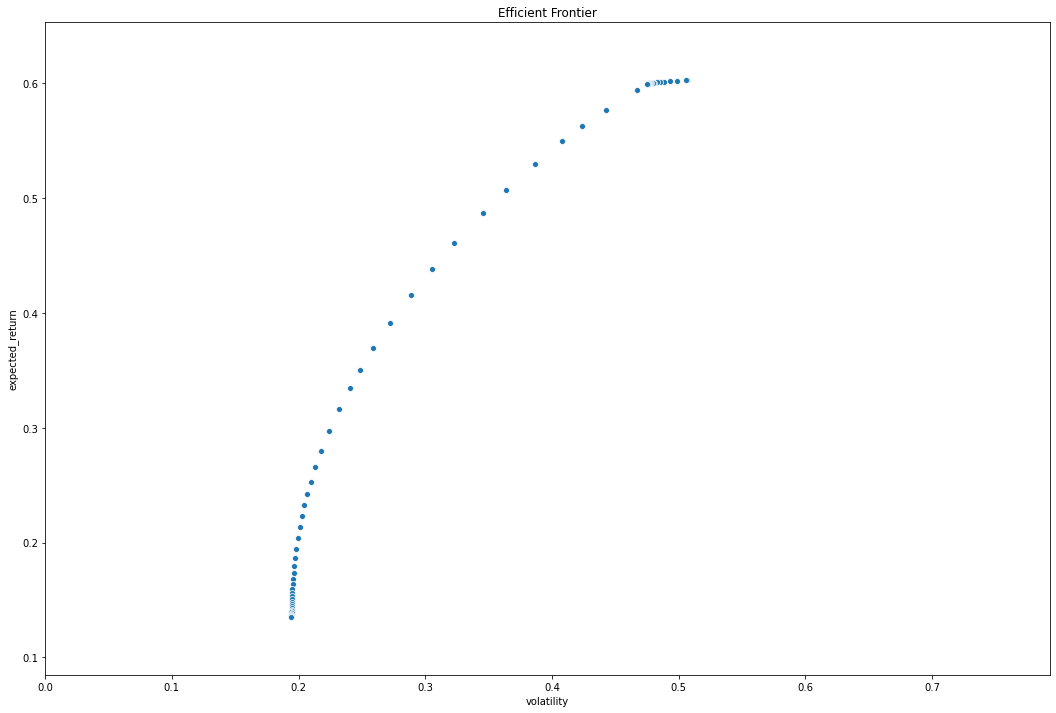

In [80]:
PortOpt.simulate_efficient_frontier(ret_format='sns', iters=100, leverage=2)

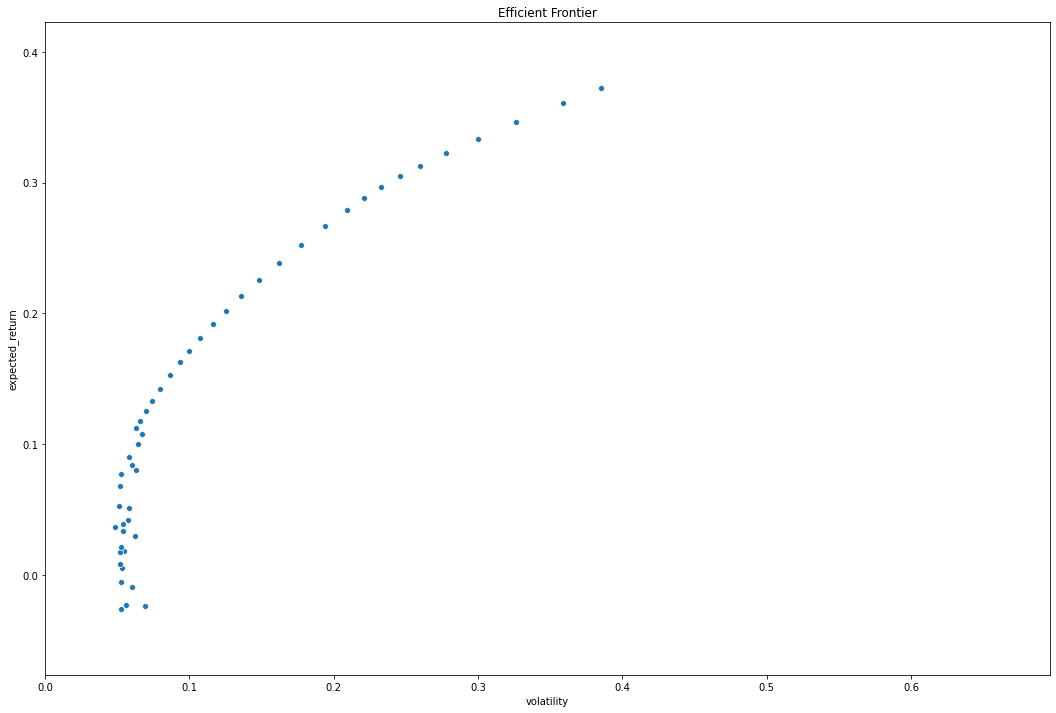

In [77]:
PortOpt.simulate_efficient_frontier(ret_format='sns', weight_bound=(-1, 1), leverage=1, iters=100)

In [78]:
PortOpt.simulate_efficient_frontier(ret_format='df', weight_bound=(-1, 1), leverage=1, iters=100).head()

volatility  expected_return  INTC  WFC  CVX  EIX  JPM  SYY  ALK  DTE  BLL  \
0      0.3855         0.372581   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1      0.3855         0.372581   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2      0.3855         0.372581   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3      0.3855         0.372581   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4      0.3855         0.372581   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    BK  NOC  IFF  DHR  OKE   LB  
0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0

#### Example: Volatility VS Expected Return
- Set x = 'volatility', y = 'expected_return'
- Choose to return an sns plot, plotly plot or a dataframe
- Specify file_path when choosing to return an sns plot to save it in your directory
- Return a plotly figure for interaction
- Return a DataFrame with simulated weights for potentially more analysis

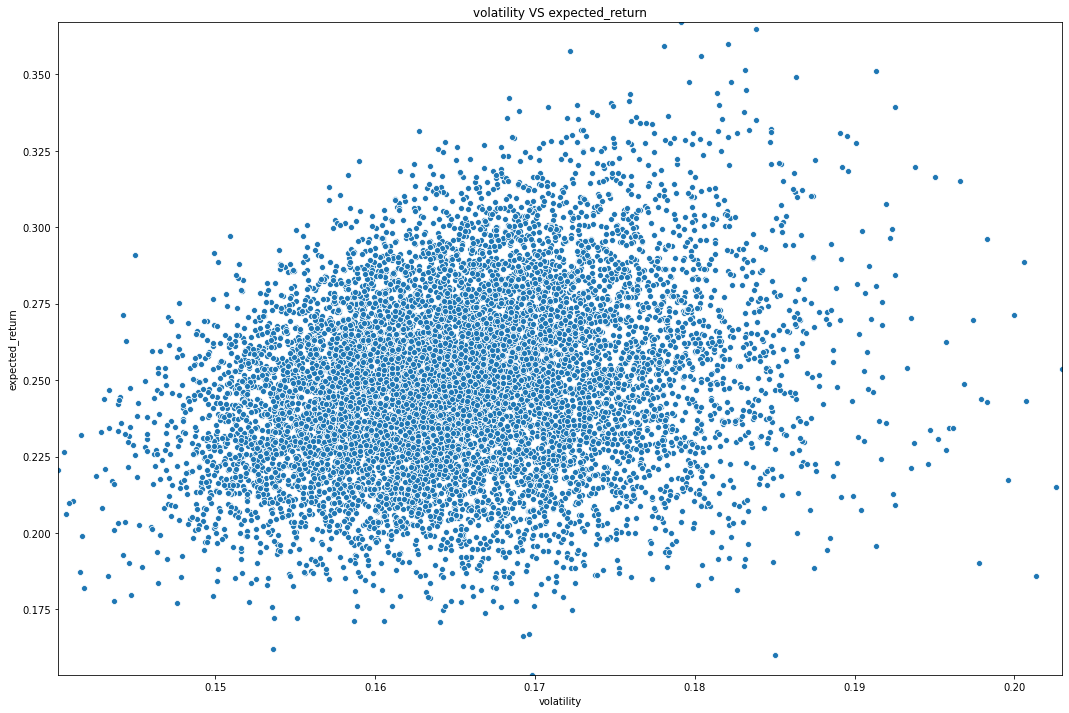

In [73]:
PortOpt.simulate(x='volatility', y='expected_return', iters=10000, weight_bound=(0, 1), leverage=1, ret_format='sns')

In [26]:
PortOpt.simulate(x='volatility', y='expected_return', iters=10000, weight_bound=(0, 1), leverage=1, ret_format='plotly')

In [27]:
sim_df = PortOpt.simulate(x='volatility', y='expected_return', iters=10000, weight_bound=(0, 1), leverage=1, ret_format='df')
sim_df.head()

volatility  expected_return        BK       SLB       TMO       BKR  \
0    0.127822         0.153120  0.019858  0.006401  0.017462  0.035966   
1    0.125808         0.147890  0.001541  0.017356  0.022637  0.050873   
2    0.123518         0.135482  0.002223  0.011717  0.023424  0.074337   
3    0.125270         0.140051  0.008283  0.017394  0.022747  0.025151   
4    0.130727         0.163921  0.007256  0.059698  0.043181  0.037098   

        IBM        SO       GLW       IPG       MCD       RJF        ES  \
0  0.023830  0.058580  0.072339  0.047987  0.072462  0.066421  0.129984   
1  0.072650  0.043240  0.064137  0.035664  0.095787  0.152125  0.066871   
2  0.041285  0.062492  0.074856  0.031374  0.062095  0.110564  0.089997   
3  0.039011  0.040296  0.033002  0.070136  0.073844  0.056228  0.098061   
4  0.054702  0.063998  0.031351  0.056961  0.045057  0.089483  0.060888   

        DTE        HP      FAST       WHR  
0  0.065821  0.083371  0.153215  0.146302  
1  0.116491  0.055252  0.088135  0.117240  
2  0.091392  0.117000  0.110736  0.096509  
3  0.099123  0.130266  0.132756  0.153703  
4  0.070454  0.074463  0.168890  0.136521

#### Add Shortselling to see the symmetric Efficient Frontier

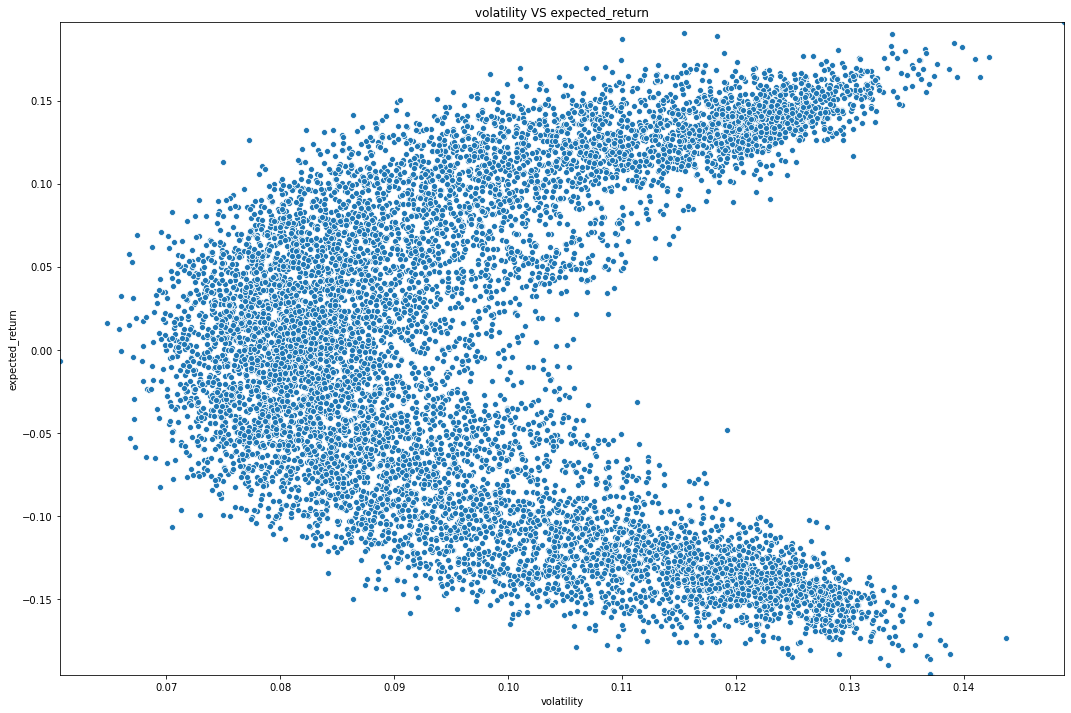

In [36]:
PortOpt.simulate(x='volatility', y='expected_return', iters=10000, weight_bound=(-0.25,0.25), leverage=1, ret_format='sns')

#### Example: Portfolio Beta & Expected Return
- The result should show a strong positive correlation

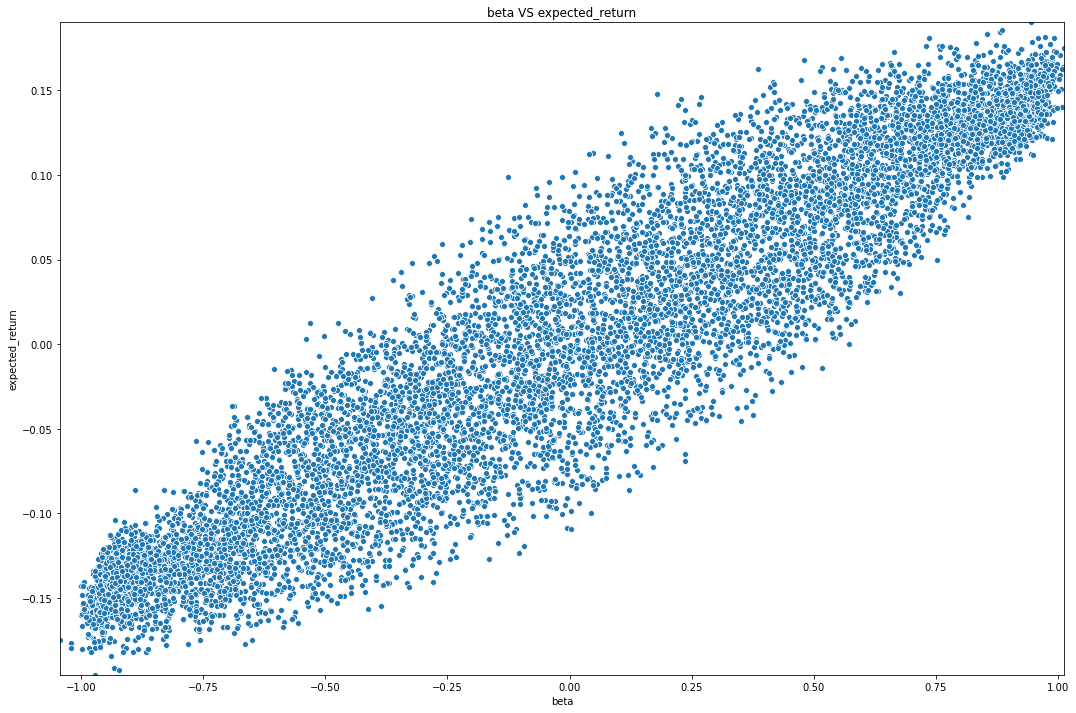

In [35]:
PortOpt.simulate(x='beta', y='expected_return', iters=10000, weight_bound=(-0.25,0.25), leverage=1, ret_format='sns')

#### Example: Portfolio Beta/Expected Return VS Sharpe Ratio
- Here, because sharpe ratio requires an additional metric, so must pass in a dictionary parameter y_var = {}

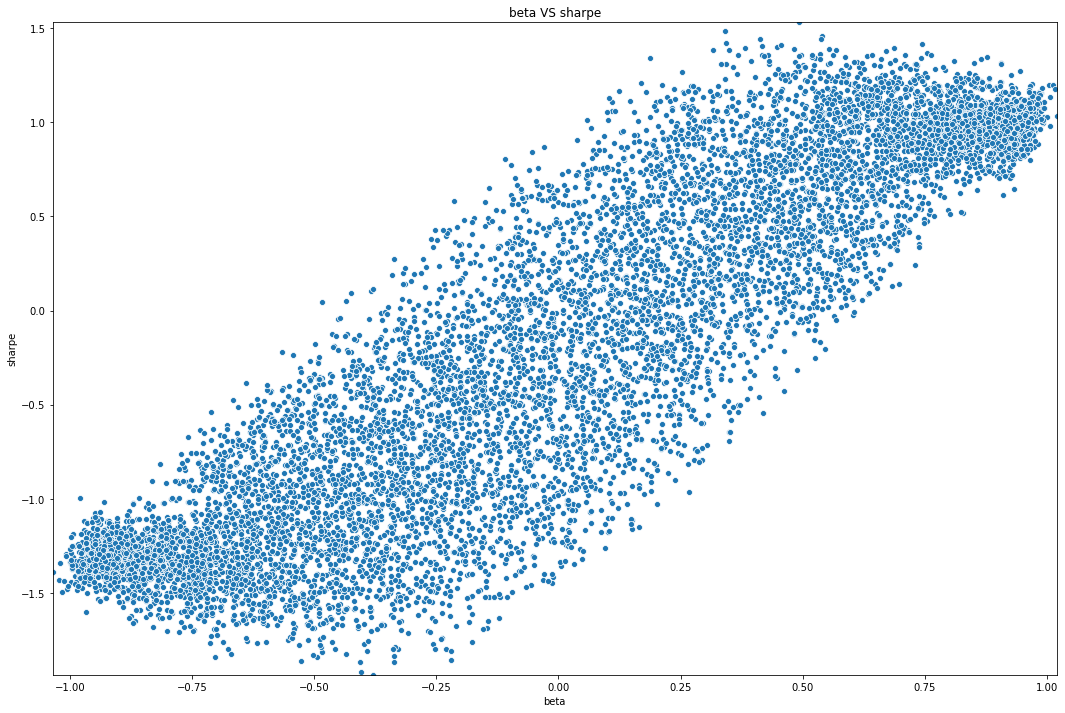

In [40]:
PortOpt.simulate(x='beta', y='sharpe', y_var={"risk_free": 0.02}, iters=10000, weight_bound=(-1, 1), leverage=1, ret_format='sns')

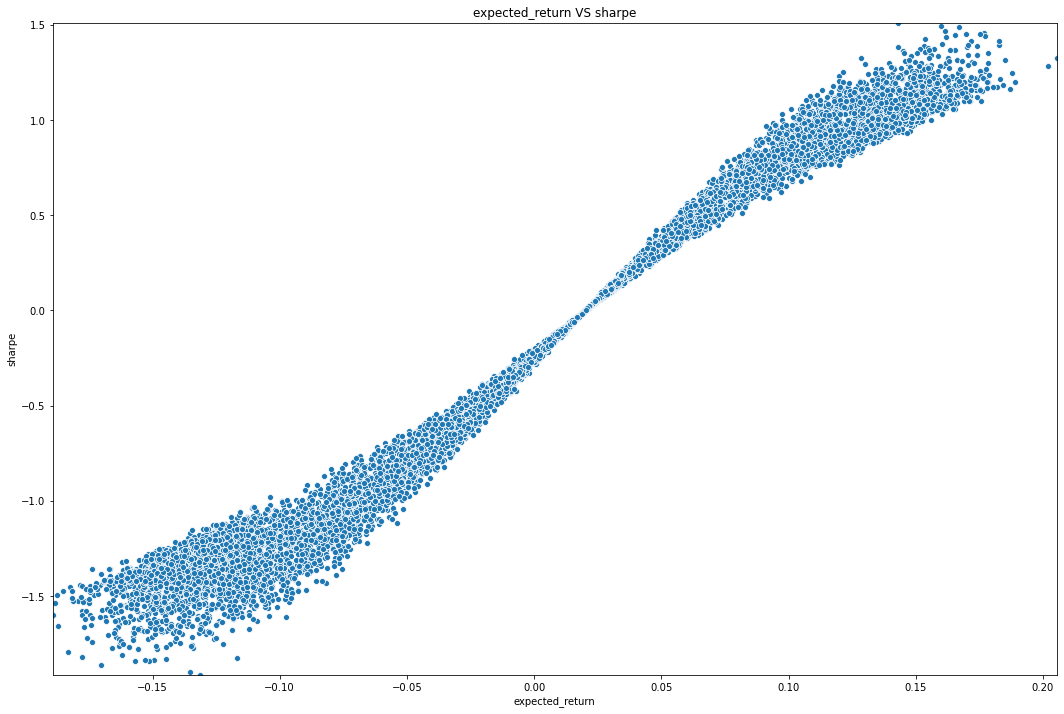

In [41]:
PortOpt.simulate(x='expected_return', y='sharpe', y_var={"risk_free": 0.02}, iters=10000, weight_bound=(-1, 1), leverage=1, ret_format='sns')

#### Example: Portfolio Beta/Expected Return VS Treynor Ratio/Jenson Alpha
- Treynor Ratio is calculated by dividing beta, so it has a lot of outliers, will use plotly to zoom in
- Jenson's Alpha calculates excess return

In [46]:
PortOpt.simulate(x='expected_return', y='treynor', y_var={"risk_free": 0.02}, iters=10000, weight_bound=(-1, 1), leverage=1, ret_format='plotly')

In [47]:
PortOpt.simulate(x='beta', y='treynor', y_var={"risk_free": 0.02}, iters=10000, weight_bound=(-1, 1), leverage=1, ret_format='plotly')

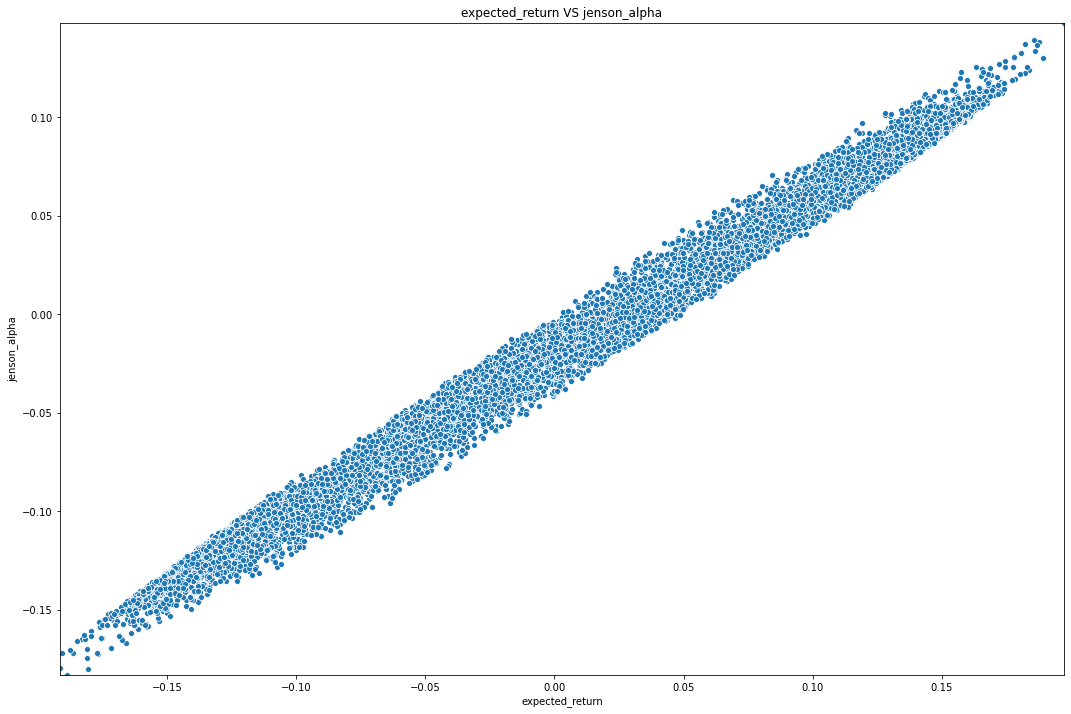

In [44]:
PortOpt.simulate(x='expected_return', y='jenson_alpha', y_var={"risk_free": 0.02, "market_return": 0.06}, iters=10000, weight_bound=(-1, 1), leverage=1, ret_format='sns')

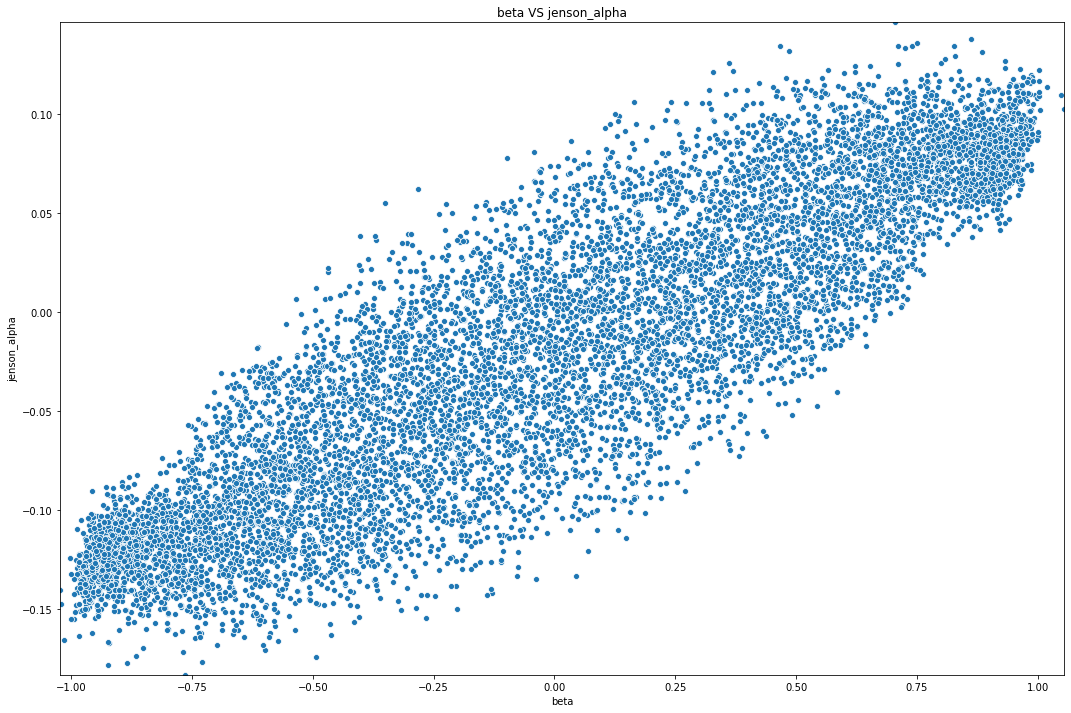

In [45]:
PortOpt.simulate(x='beta', y='jenson_alpha', y_var={"risk_free": 0.02, "market_return": 0.06}, iters=10000, weight_bound=(-1, 1), leverage=1, ret_format='sns')

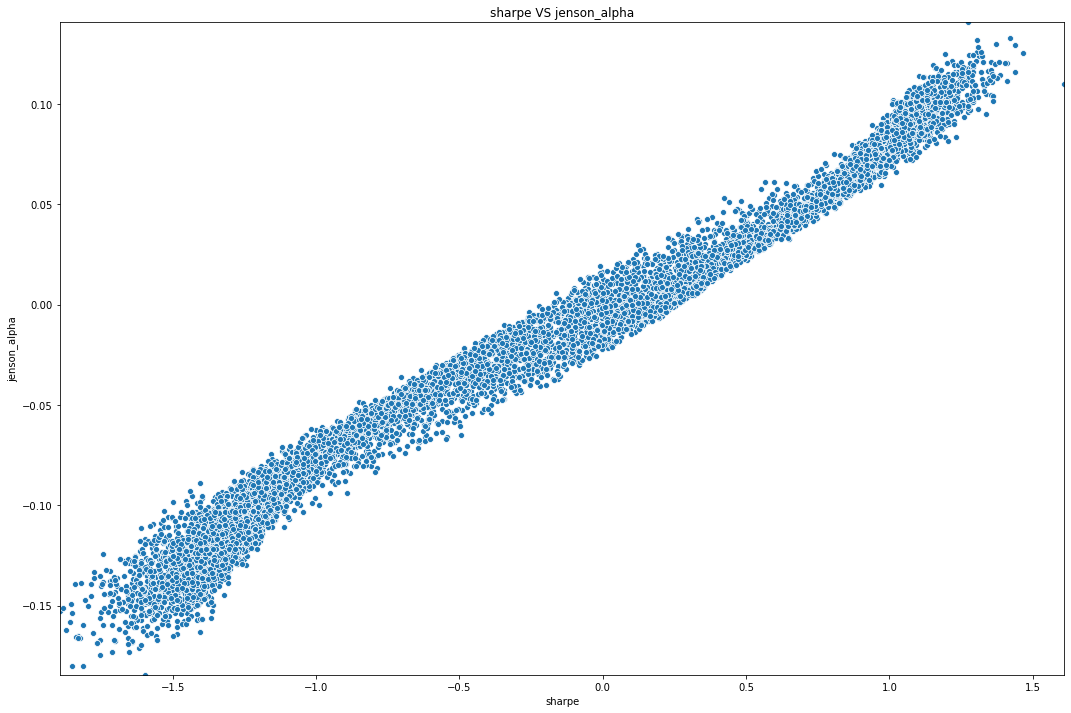

In [48]:
PortOpt.simulate(x='sharpe', y='jenson_alpha', x_var={"risk_free": 0.02}, y_var={"risk_free": 0.02, "market_return": 0.06}, iters=10000, weight_bound=(-1, 1), leverage=1, ret_format='sns')

### Simulate Efficient Frontier for Skewness/Kurtosis
- More Negatively Skewed Portfolio has higher expected return/higher beta, though the relationship is not strictly linear
- 4th Central Moment (Kurtosis) Has an Efficient Frontier resembles 2nd Central Moment (Variance)

In [61]:
coskew_matrix = mom_generator.calc_coskew_mat()
PortOpt = Optimizer(mu_return, coskew_matrix, beta_vec)

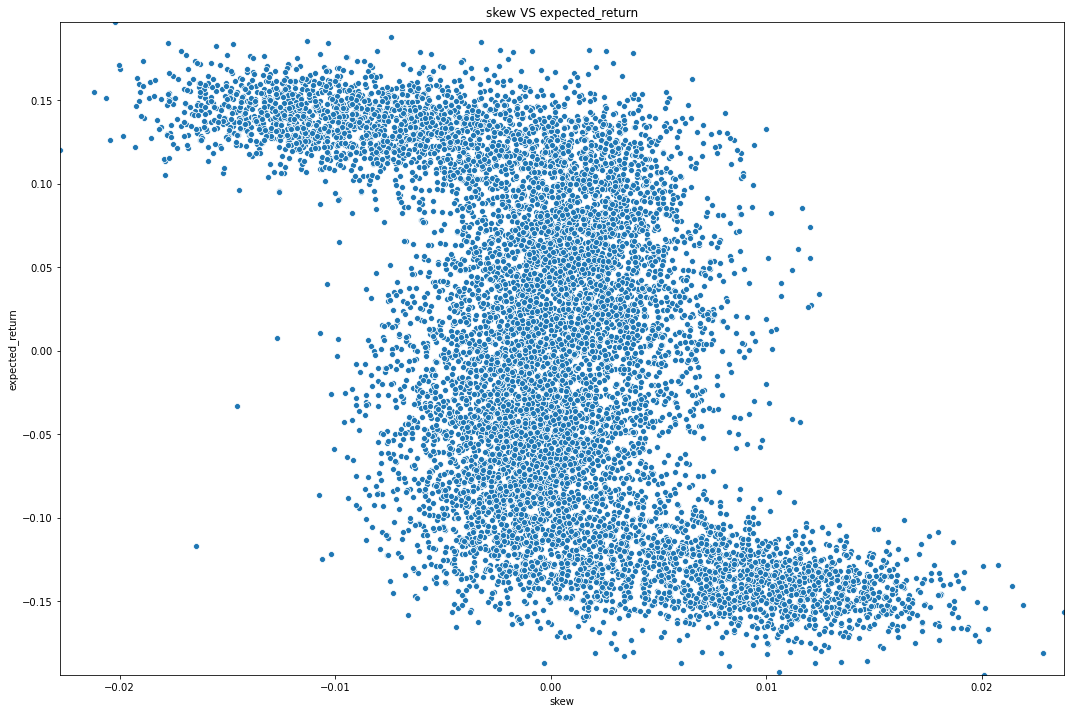

In [62]:
PortOpt.simulate(x='skew', y='expected_return', iters=10000, weight_bound=(-1, 1), leverage=1, ret_format='sns')

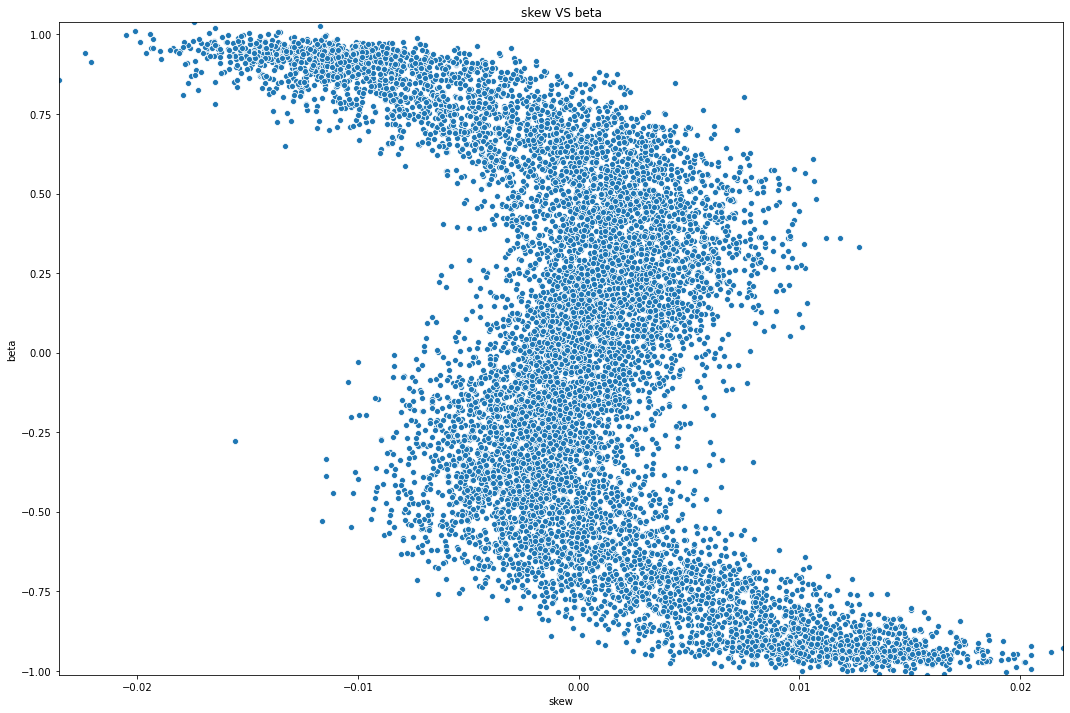

In [63]:
PortOpt.simulate(x='skew', y='beta', iters=10000, weight_bound=(-1, 1), leverage=1, ret_format='sns')

In [65]:
mom_generator = MomentGenerator(daily_return.iloc[:200])

In [66]:
cokurt_matrix = mom_generator.calc_cokurt_mat()
PortOpt = Optimizer(mu_return, cokurt_matrix, beta_vec)

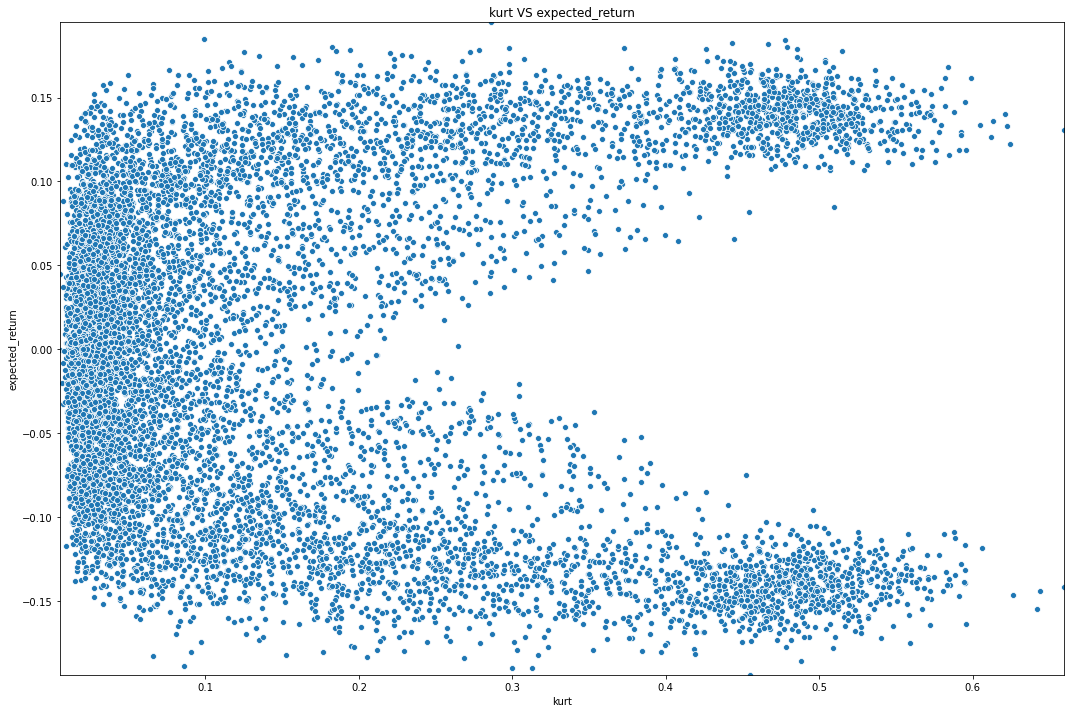

In [67]:
PortOpt.simulate(x='kurt', y='expected_return', iters=10000, weight_bound=(-1, 1), leverage=1, ret_format='sns')

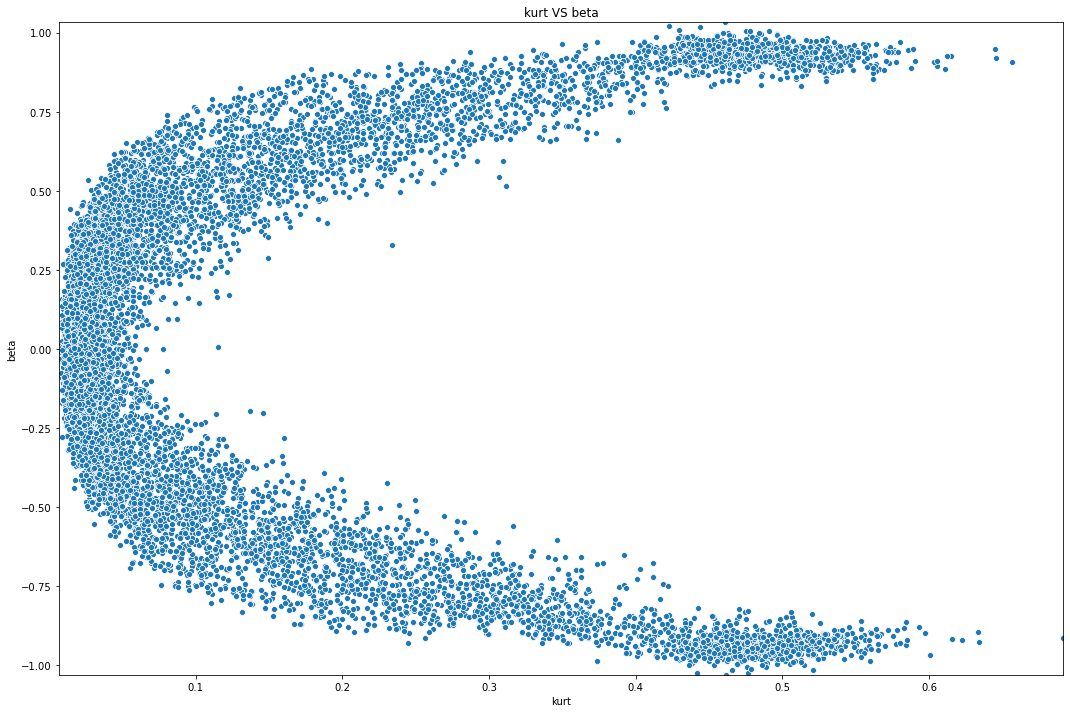

In [68]:
PortOpt.simulate(x='kurt', y='beta', iters=10000, weight_bound=(-1, 1), leverage=1, ret_format='sns')

### Higher Moment Simulation
- Example of 5th Moment Simulation

In [19]:
mom_generator = MomentGenerator(daily_return.iloc[:100])
comoment_matrix = mom_generator.calc_comoment_mat(moment=5)
PortOpt = Optimizer(mu_return, comoment_matrix, beta_vec)

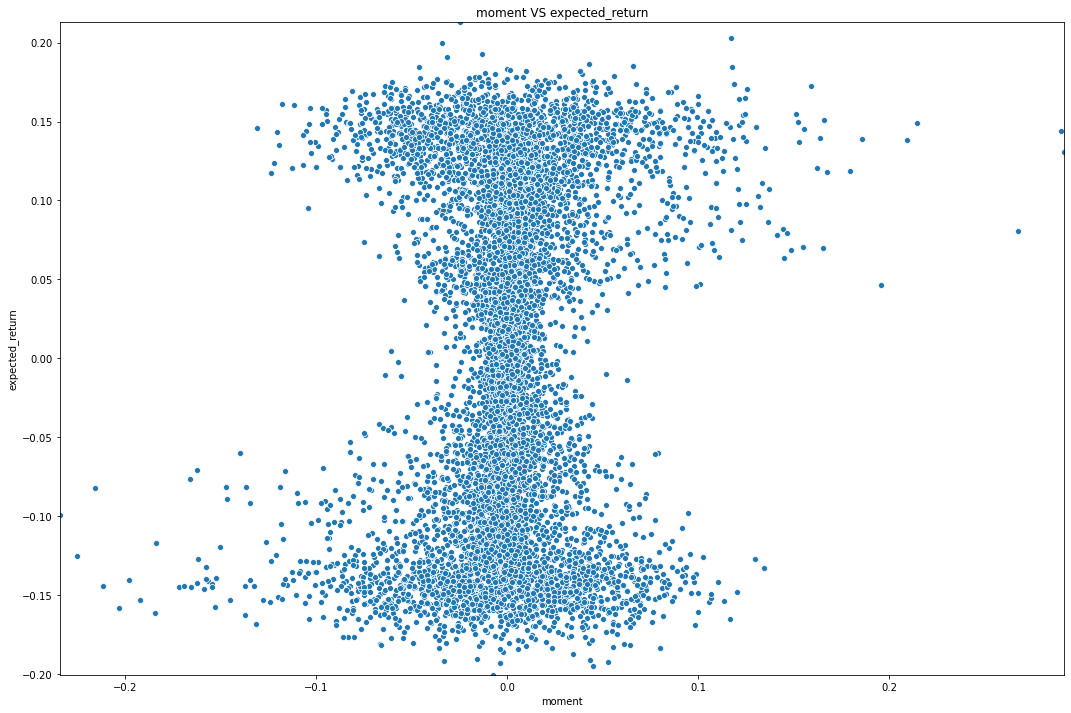

In [20]:
PortOpt.simulate(x='moment', y='expected_return', iters=10000, weight_bound=(-1, 1), leverage=1, ret_format='sns')